$\textbf{Medición del riesgo del anual y diario del portafolio mediante el VaR}$  

Alumno: Saavedra Pérez Miguel Rodrigo



In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm

In [171]:
#Lectura de información
data=pd.read_excel("var clase 01abr20.xlsx","Precios",index_col=0)

## Optimización de los pesos

In [172]:
rend=data.pct_change().dropna()
#PESOS ALEATORIOS
weights = np.random.random(5)
weights/= sum(weights)
weights

array([0.1769089 , 0.27902478, 0.22590977, 0.17001257, 0.14814398])

In [173]:
#Funciones de rendimiento y volatilidad del portafolio (anual y diario)

#Rendimiento del portafolio anual
def port_rend_a(weights, r):
    E_p = (r.mean() @ weights).sum()*252
    return E_p

#Rendimiento del portafolio diario
def port_rend_d(weights, r):
    E_p = (r.mean() @ weights).sum()
    return E_p

#Volatilidad del portafolio anual
def port_vol_a(weights, r):
    S_p = np.sqrt(weights.T@(r.cov()*252) @ weights)
    return S_p

#Volatilidad del portafolio diaria
def port_vol_d(weights, r):
    S_p = np.sqrt(weights.T@(r.cov()) @ weights)
    return S_p

In [174]:
weights_sim = np.random.random((5000,5))
weights_sim=weights_sim/weights_sim.sum(axis=1, keepdims=True)

rend_sim_a= np.apply_along_axis(port_rend_a, 1, weights_sim, r=rend)
vol_sim_a= np.apply_along_axis(port_vol_a, 1, weights_sim, r=rend)

Text(0, 0.5, 'E(r)')

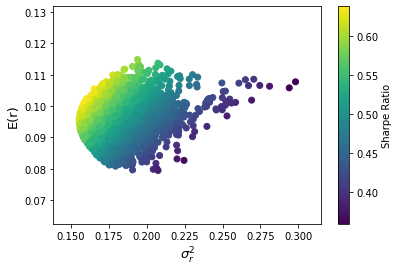

In [175]:
sharpe_ratio = rend_sim_a / vol_sim_a
plt.scatter(vol_sim_a, rend_sim_a, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13)

## Frontera eficiente

Calcularemos los portafolios de mínima varianza y que maximizan el radio de Sharpe

In [176]:
#Funciones que utilizaremos para los contraints
N, M = rend.shape
w0 = np.random.randn(M)

#Restricciones
def sum_weights(weights):
    return weights.sum()-1

def asig(weights,i,j):
    w1 = weights[i]
    w2 = weights[j]    
    return -(w1+w2)/2 + 0.5

def asig2(weights):
    return min(weights) + 0.08

#Maximiza el sharpe-ratio dado un rendimiento
def rend_esperado(weights, E):
    return port_rend_a(weights, rend) - E

## Optimización sujeta a un rendimiento esperado

In [177]:
rend_ports = rend.mean() * 252
r_min=rend_ports.min()
r_max=rend_ports.max()

rend_max = np.linspace(r_min, r_max)

pesos_optimos = []
N, M = rend.shape
w_opt = np.random.randn(M)

for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w,e)},
        {"type": "ineq", "fun": lambda w: asig(w,0,1)},
        {"type": "ineq", "fun": lambda w: asig(w,0,2)},
        {"type": "ineq", "fun": lambda w: asig(w,0,3)},
        {"type": "ineq", "fun": lambda w: asig(w,0,4)},
        {"type": "ineq", "fun": lambda w: asig(w,1,2)},
        {"type": "ineq", "fun": lambda w: asig(w,1,3)},
        {"type": "ineq", "fun": lambda w: asig(w,1,4)},
        {"type": "ineq", "fun": lambda w: asig(w,2,3)},
        {"type": "ineq", "fun": lambda w: asig(w,2,4)},
        {"type": "ineq", "fun": lambda w: asig(w,3,4)},
        {"type": "ineq", "fun": asig2}
    ]

    port_opt = minimize(port_vol_a, w_opt,  constraints = constraints, args=rend)
    w_opt = port_opt.x
    pesos_optimos.append(w_opt)

In [178]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend_a(w,rend))
    v_opt.append(port_vol_a(w,rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

In [179]:
pesos_optimos1 = []
N, M = rend.shape
w_opt1 = np.random.randn(M)

for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
    ]

    port_opt1 = minimize(port_vol_a, w_opt1,  constraints = constraints, args=rend)
    w_opt1 = port_opt1.x
    pesos_optimos1.append(w_opt1)

Portafolio de mínima varianza sin restricciones adicionales: [-0.13168987 -0.39969964 -1.23788372 -0.98306305 -0.68955398]
Portafolio que maximiza el radio de Sharpe : [0.28243813 0.04436736 0.0901176  0.3072886  0.27578831]


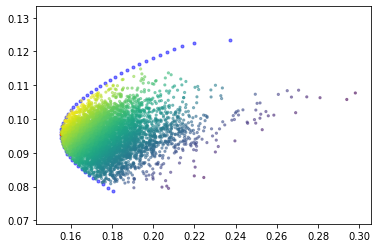

In [180]:
r_opt1 = []
v_opt1 = []

for w in pesos_optimos1:
    r_opt1.append(port_rend_a(w,rend))
    v_opt1.append(port_vol_a(w,rend))

r_opt1 = np.array(r_opt1)
v_opt1 = np.array(v_opt1)

plt.scatter(v_opt,r_opt, c= "blue",linewidths=1,alpha=.5,marker = ".")
plt.scatter(v_opt1,r_opt1, c= "red",linewidths=.01,alpha=.5,marker = ".")
plt.scatter(vol_sim_a, rend_sim_a, c=sharpe_ratio, alpha = 0.5, s=5)

print(f"Portafolio de mínima varianza sin restricciones adicionales: {np.random.randn(M)}")
print(f"Portafolio que maximiza el radio de Sharpe : {port_opt1.x}")

## Portafolio Tangencial

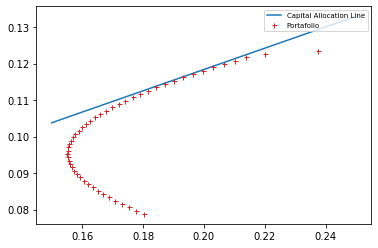

In [182]:
#Finalmente genramos la CAL junto con su gràfica, realizando el overlay con las fronteras de los 2 portafolios generados.
rf = 0.06
w0 = np.random.randn(M)

def min_func_sharpe(weights):
    return - (port_rend_a(weights, rend) - rf)/port_vol_a(weights,rend)

constraints2 = [
    {"type": "eq","fun":sum_weights}
]

f_sharpe = minimize(min_func_sharpe, w0, constraints = constraints2)
w_sharpe = f_sharpe.x
e_sharpe = port_rend_a(w_sharpe,rend)
vol_sharpe = port_vol_a(w_sharpe, rend)

sigma_c = np.linspace(.15,0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.plot(sigma_c,sharpe, linestyle = "-", c= "tab:blue",label = "Capital Allocation Line")
plt.plot(v_opt,r_opt,linestyle = "",marker="+",markersize=5.0, c= "tab:red",label = "Portafolio")
plt.legend(fontsize=7, loc ='upper right' )

### VaR del portafolio e individual

In [234]:
#Definimos función para el calculo de VaR
def VaR_individual(S, w, F, rend, portafolio="portafolio"):
    if portafolio=="portafolio":
        #Volatilidad anual y diaria
        vol_anual, var_anual = port_vol_a(w, rend), port_vol_a(w, rend)**2
        vol_diario, var_diario= port_vol_d(w, rend), port_vol_d(w, rend)**2
        #Valor en riesgo del portafolio
        VaR_anual, VaR_diario=F*S*vol_anual, F*S*vol_diario
        print(f"El VaR diario por portafolio es: {VaR_diario:,}\n\nEl VaR anual por portafolio es: {VaR_anual:,}")
        return {"VaR_anual": VaR_anual, 
                "VaR_diario": VaR_diario}
    elif portafolio=="individual":
        VaR_ind_diario={k:w[i]*S*F*np.sqrt(rend.cov().iloc[0].iloc[0]) for i,k in enumerate(list(rend.keys()))}
        VaR_ind_anual={k:(np.sqrt(252))*w[i]*S*F*np.sqrt(rend.cov().iloc[0].iloc[0])for i,k in enumerate(llaves)}
        print(f"El VaR diario por equity es: {VaR_ind_diario}\n\nSuma diaria: {sum(VaR_ind_diario.values()):,}\n\nEl VaR anual por equity es: {VaR_ind_anual}\n\nSuma anual: {sum(VaR_ind_anual.values()):,}")
        return {"VaR_ind_diario": VaR_ind_diario, 
                "VaR_ind_anual": VaR_ind_anual, 
                "sum_VaR_ind_diario": sum(VaR_ind_diario.values()), 
                "sum_VaR_ind_anual": sum(VaR_ind_anual.values())}
    else:
        print("Selecciona la variable portafolio como 'portafolio' o 'individual'")
        

In [233]:
VaR_individual(10000000, port_opt1.x, norm.ppf(0.95,loc=0,scale=1), rend, "individual")

El VaR diario por equity es: {'ASURB MF Equity': 69497.87960507495, 'GFNORTEO MF Equity': 10917.21473998962, 'PE&OLES* MF Equity': 22174.70550514101, 'WALMEX* MF Equity': 75612.68787730426, 'IENOVA* MF Equity': 67861.59854589523}

Suma diaria: 246,064.08627340506

El VaR anual por equity es: {'ASURB MF Equity': 1103244.6364880167, 'GFNORTEO MF Equity': 173305.41126900725, 'PE&OLES* MF Equity': 352012.5369761881, 'WALMEX* MF Equity': 1200314.2085069723, 'IENOVA* MF Equity': 1077269.4799424477}

Suma anual: 3,906,146.2731826315


{'VaR_ind_diario': {'ASURB MF Equity': 69497.87960507495,
  'GFNORTEO MF Equity': 10917.21473998962,
  'PE&OLES* MF Equity': 22174.70550514101,
  'WALMEX* MF Equity': 75612.68787730426,
  'IENOVA* MF Equity': 67861.59854589523},
 'VaR_ind_anual': {'ASURB MF Equity': 1103244.6364880167,
  'GFNORTEO MF Equity': 173305.41126900725,
  'PE&OLES* MF Equity': 352012.5369761881,
  'WALMEX* MF Equity': 1200314.2085069723,
  'IENOVA* MF Equity': 1077269.4799424477},
 'sum_VaR_ind_diario': 246064.08627340506,
 'sum_VaR_ind_anual': 3906146.2731826315}

In [235]:
VaR_individual(10000000, port_opt1.x, norm.ppf(0.95,loc=0,scale=1), rend, "portafolio")

El VaR diario por portafolio es: 160,772.79323185238

El VaR anual por portafolio es: 2,552,188.9708601385


{'VaR_anual': 2552188.9708601385, 'VaR_diario': 160772.79323185238}